# Theory Analysis at given quantile across latitudes
This notebook applies the adiabatic theory for convectively set change in temperature to a range of latitudes.

It is adapted from the [theory breakdown.ipynb](https://github.com/jduffield65/Isca/blob/main/jobs/tau_sweep/land/meridional_band/publish_figures/theory_breakdown.ipynb) notebook used for Isca simulations.

In [1]:
import copy
import sys
import os

import warnings


# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, R
from isca_tools.utils import area_weighting
from isca_tools.thesis.adiabat_theory2 import get_scale_factor_theory, get_approx_terms, get_sensitivity_factors, get_cape_approx
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import integrate
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
import matplotlib
# matplotlib.rcParams['lines.linewidth'] = 1.2          # make lines bigger for presentation

In [2]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05
im_sz = 1.5

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

#### Load in Data
Quantile data is obtained from CESM datasets and output into npz files. Here I am just interested in the npz files. For quantile data, the shape of array is `[2, n_lat, n_quant]` where the first index is `0` for land and `1` for ocean coordinates (quantiles are found separately at each latitude for land and ocean).

In [3]:
dir_out = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/theory_adiabat/hottest_lat_lon'
exp_id = ['pre_industrial', 'co2_2x']
n_exp = len(exp_id)
exp_names = []
for i in range(n_exp):
    if exp_id[i] == 'pre_industrial':
        exp_names.append('e.e20.E1850TEST.f09_g17.daily_output')
    else:
        exp_names.append(f'e.e20.E1850TEST.f09_g17.{exp_id[i]}_daily_output')
# exp_names = ['e.e20.E1850TEST.f09_g17.daily_output', 'e.e20.E1850TEST.f09_g17.co2_2x_daily_output']
# exp_names = ['isca/tau_sweep.land.meridional_band.depth=1.bucket_evap.k=1', 'isca/tau_sweep.land.meridional_band.depth=1.bucket_evap.k=2']

# if not np.all(ds_base[0]['quant']==ds_base[1]['quant']):
#     raise ValueError('Quantiles change between datasets')
#
# if not np.all(ds_base[0]['lat']==ds_base[1]['lat']):
#     raise ValueError('Latitudes change between datasets')
#
# if not np.all(ds_base[0]['surface']==ds_base[1]['surface']):
#     raise ValueError('Surface change between datasets')
ds = []
for i in tqdm(range(n_exp)):
    ds.append(xr.open_dataset(os.path.join(dir_out, f'{exp_id[i]}/output.nd2')).isel(quant=0, drop=True).load())
    # Find all latitudes with at least one longitude of given surface
    # ds[i]['is_surf'] = (ds[i].landmask.sum(dim='lon')!=0) * (ds[i].surface=='land') + (
    #         np.invert(ds[i].landmask).sum(dim='lon')!=0) * (ds[i].surface=='ocean')
    # ds[i] = ds[i].where(ds[i].is_surf)      # set values to nan where there is none of that surface at given latitude
ds_av = xr.open_dataset(os.path.join(dir_out, f'{exp_id[0]}/av/output.nd2')).isel(quant=0, drop=True)[['Z3', 'T']].load()
ds_av = area_weighting(ds_av).mean(dim=['lat', 'lon'])          # take global av

  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
# Get pressure info
ind_surf = 0
ind_ft = 1
pressure_surf = float(ds[0].lev[ind_surf]) * 100
pressure_ft = float(ds[0].lev[ind_ft]) * 100

## Geopotential Height - Temperature Relation
### Lapse Rate
#### Zhang 2023
In the Zhang 2023 formulation, the factor $\zeta = \frac{z_{500} - z_s}{T_{500}}$ is assumed constant on all days, and thus takes its value in the global average, $\overline{\beta}$.

The lapse rate is related to $\zeta$ through $\Gamma = \frac{T_s-T_{500}}{z_{500}-z_s} = \frac{T_s/T_{500}-1}{\zeta}$

The key point is that $\zeta$ and not the lapse rate itself is constant across all days.

#### My theory
In my theory, the lapse rate is given by:

$$
\frac{1}{\Gamma} = \frac{2R^{\dagger}}{g\ln\left(\frac{T_s}{T_{FT}}\right)} \approx \frac{2R^{\dagger}}{g}\left(\frac{T_{FT}}{T_s-T_{FT}} + \frac{1}{2}\right)
$$
where we have introduced for convenience a modified gas constant $R^{\dagger} \equiv R\ln \left(\frac{p_s}{p_{FT}}\right)/2$, and the approximation arises from re-writing the denominator in the form $\ln(1+y)$, with $y = \frac{T_s-T_{FT}}{T_{FT}}$.

Both estimates seem pretty similar.

In [109]:
def get_lapse_theory(temp_surf, temp_ft, p_surf=pressure_surf, p_ft=pressure_ft, taylor=True):
    R_mod = R * np.log(p_surf / p_ft)/2
    if taylor:
        return g / 2 / R_mod / (temp_ft/(temp_surf - temp_ft) + 0.5)
    else:
        return g * np.log(temp_surf/temp_ft) / 2 / R_mod

def get_lapse_rate_zhang(temp_surf, temp_ft):
    zeta_factor = float((ds_av.Z3.isel(lev=ind_ft)-ds_av.Z3.isel(lev=ind_surf))/ds_av.T.isel(lev=ind_ft))
    return (temp_surf/temp_ft - 1) / zeta_factor

def get_lapse_rate(temp_surf, temp_ft, z_surf, z_ft):
    return (temp_surf - temp_ft) / (z_ft - z_surf)

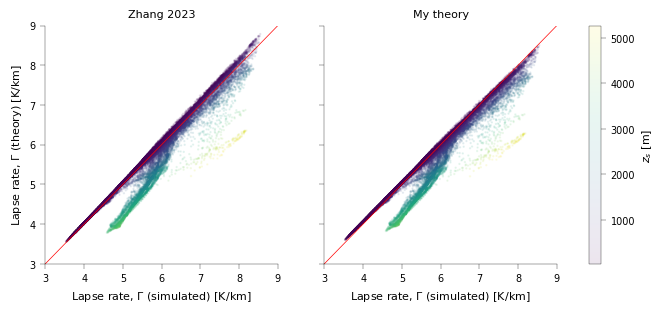

In [111]:
i = 0
show_scatter = True
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['two_col'])
im = ax[0].scatter(get_lapse_rate(ds[i].T.isel(lev=0), ds[i].T.isel(lev=1), ds[i].Z3.isel(lev=0), ds[i].Z3.isel(lev=1))*1000,
                   get_lapse_rate_zhang(ds[i].T.isel(lev=0), ds[i].T.isel(lev=1), ds[i].Z3.isel(lev=0))*1000,
                   alpha=0.1, c=ds[0].Z3.isel(lev=0), cmap='viridis', s=0.5)
im = ax[1].scatter(get_lapse_rate(ds[i].T.isel(lev=0), ds[i].T.isel(lev=1), ds[i].Z3.isel(lev=0), ds[i].Z3.isel(lev=1))*1000,
                   get_lapse_theory(ds[i].T.isel(lev=0), ds[i].T.isel(lev=1), taylor=False)*1000,
                   alpha=0.1, c=ds[0].Z3.isel(lev=0), cmap='viridis', s=0.5)
plt.colorbar(im, ax=ax, label='$z_{s}$ [m]')
ax_lim = [3, 9]
ax[0].plot(ax_lim, ax_lim, color='r')
ax[1].plot(ax_lim, ax_lim, color='r')
ax[0].set_ylim(ax_lim)
ax[0].set_xlim(ax_lim)
ax[0].set_xlabel('Lapse rate, $\Gamma$ (simulated) [K/km]')
ax[1].set_xlabel('Lapse rate, $\Gamma$ (simulated) [K/km]')
ax[0].set_ylabel('Lapse rate, $\Gamma$ (theory) [K/km]')
ax[0].set_title('Zhang 2023')
ax[1].set_title('My theory')
if show_scatter:
    plt.show()
else:
    plt.close()

### Height
Given the lapse rate, it is a simple conversion to get an estimate of the geopotential height relative to the surface, $z_{FT}-z_s$. Again, it seems that both theories do equally as well, maybe the Zhang 2023 theory is slightly better.

In [116]:
def get_z_theory(temp_surf, temp_ft, p_surf=pressure_surf, p_ft=pressure_ft, taylor=True):
    # Returns z_ft - z_s
    R_mod = R * np.log(p_surf / p_ft)/2
    if taylor:
        return R_mod/g * (temp_surf + temp_ft)
    else:
        return (temp_surf - temp_ft) * 2 * R_mod / g / np.log(temp_surf / temp_ft)

def get_z_theory_zhang(temp_ft):
    # Returns z_ft - z_s theory
    zeta_factor = float((ds_av.Z3.isel(lev=ind_ft)-ds_av.Z3.isel(lev=ind_surf))/ds_av.T.isel(lev=ind_ft))
    return zeta_factor * temp_ft

In [119]:
z_diff = {'simulated': [(ds[i].Z3.isel(lev=1)-ds[i].Z3.isel(lev=0)) for i in range(n_exp)],
          'zhang': [get_z_theory_zhang(ds[i].T.isel(lev=1)) for i in range(n_exp)],
          'theory': [get_z_theory(ds[i].T.isel(lev=0), ds[i].T.isel(lev=1)) for i in range(n_exp)]}

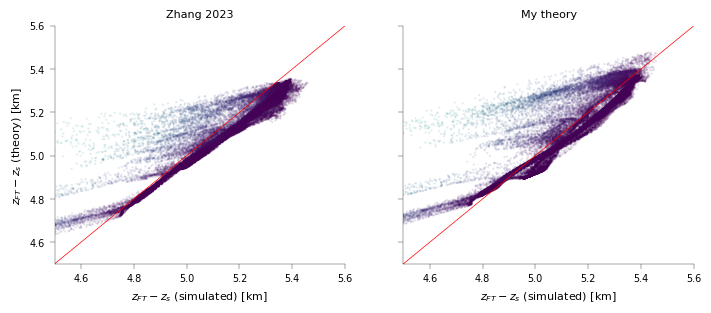

In [139]:
i=0
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['two_col'])
ax[0].scatter(z_diff['simulated'][i]/1000, z_diff['zhang'][i]/1000,
              alpha=0.1, c=ds[i].Z3.isel(lev=0), cmap='viridis', s=0.5)
ax[1].scatter(z_diff['simulated'][i]/1000, z_diff['theory'][i]/1000,
              alpha=0.1, c=ds[i].Z3.isel(lev=0), cmap='viridis', s=0.5)
ax_lim = [4.5, 5.6]
ax[0].plot(ax_lim, ax_lim, color='r')
ax[1].plot(ax_lim, ax_lim, color='r')
ax[0].set_ylim(ax_lim)
ax[0].set_xlim(ax_lim)
ax[0].set_xlabel('$z_{FT}-z_s$ (simulated) [km]')
ax[1].set_xlabel('$z_{FT}-z_s$ (simulated) [km]')
ax[0].set_ylabel('$z_{FT}-z_s$ (theory) [km]')
ax[0].set_title('Zhang 2023')
ax[1].set_title('My theory')
if show_scatter:
    plt.show()
else:
    plt.close()

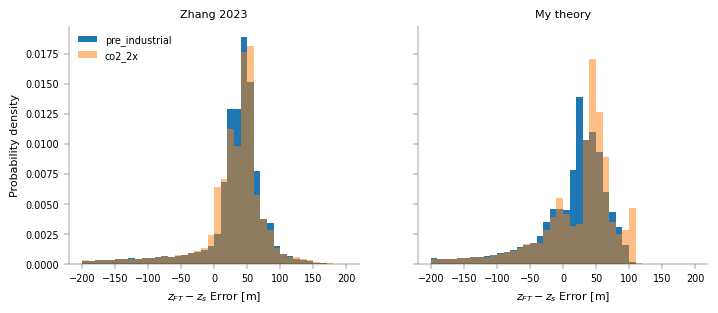

In [140]:
hist_bins = np.linspace(-200, 200, 41)
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['two_col'])
for i in range(n_exp):
    ax[0].hist((z_diff['simulated'][i]-z_diff['zhang'][i]).to_numpy().flatten(), bins=hist_bins, density=True, alpha=0.5 if i==1 else 1, label=exp_id[i])
    ax[1].hist((z_diff['simulated'][i]-z_diff['theory'][i]).to_numpy().flatten(), bins=hist_bins, density=True, alpha=0.5 if i==1 else 1)
ax[0].set_xlabel('$z_{FT}-z_s$ Error [m]')
ax[1].set_xlabel('$z_{FT}-z_s$ Error [m]')
ax[0].set_ylabel('Probability density')
ax[0].set_title('Zhang 2023')
ax[1].set_title('My theory')
ax[0].legend()
plt.show()

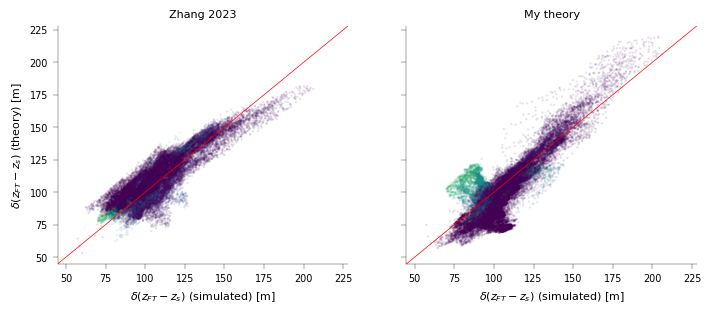

In [129]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['two_col'])
ax[0].scatter(np.diff(z_diff['simulated'], axis=0).squeeze(), np.diff(z_diff['zhang'], axis=0).squeeze(),
              alpha=0.1, c=ds[i].Z3.isel(lev=0), cmap='viridis', s=0.5)
ax[1].scatter(np.diff(z_diff['simulated'], axis=0).squeeze(), np.diff(z_diff['theory'], axis=0).squeeze(),
              alpha=0.1, c=ds[i].Z3.isel(lev=0), cmap='viridis', s=0.5)
ax_lim = [150, 450]
ax_lim = ax[0].get_ylim()
ax[0].plot(ax_lim, ax_lim, color='r')
ax[1].plot(ax_lim, ax_lim, color='r')
ax[0].set_ylim(ax_lim)
ax[0].set_xlim(ax_lim)
ax[0].set_xlabel('$\delta (z_{FT}-z_s)$ (simulated) [m]')
ax[1].set_xlabel('$\delta (z_{FT}-z_s)$ (simulated) [m]')
ax[0].set_ylabel('$\delta (z_{FT}-z_s)$ (theory) [m]')
ax[0].set_title('Zhang 2023')
ax[1].set_title('My theory')
if show_scatter:
    plt.show()
else:
    plt.close()

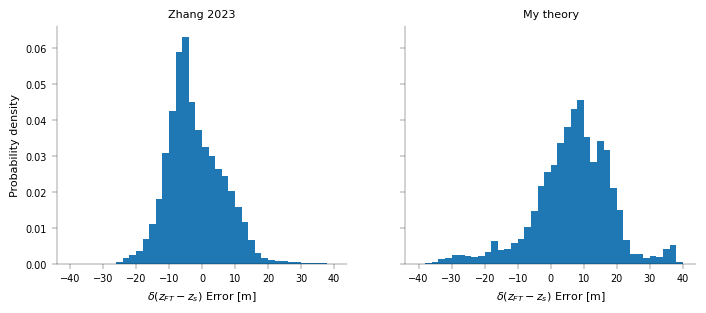

In [141]:
hist_bins = np.linspace(-40, 40, 41)
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['two_col'])
ax[0].hist((np.diff(z_diff['simulated'], axis=0).squeeze()-
            np.diff(z_diff['zhang'], axis=0).squeeze()).flatten(), bins=hist_bins, density=True)
ax[1].hist((np.diff(z_diff['simulated'], axis=0).squeeze()-
            np.diff(z_diff['theory'], axis=0).squeeze()).flatten(), bins=hist_bins, density=True)
# ax[1].hist((z_diff['simulated'][i]-z_diff['theory'][i]).to_numpy().flatten(), bins=hist_bins, density=True, alpha=0.5 if i==1 else 1)
ax[0].set_xlabel('$\delta (z_{FT}-z_s)$ Error [m]')
ax[1].set_xlabel('$\delta (z_{FT}-z_s)$ Error [m]')
ax[0].set_ylabel('Probability density')
ax[0].set_title('Zhang 2023')
ax[1].set_title('My theory')
plt.show()

In [12]:
# Get reference dataset
lat_ref_approx = 0.4
ind_lat_ref = int(np.abs(ds[0].lat-lat_ref_approx).argmin())
lat_ref = float(ds[0].lat[ind_lat_ref])
ds_ref = [ds[i].isel(lat=ind_lat_ref) for i in range(n_exp)]


In [179]:
def get_temp_change_zhang_theory(temp_ft, sphum=None, p_ft=pressure_ft):
    temp_ft_change = temp_ft[1] - temp_ft[0]
    zeta_factor = float((ds_av.Z3.isel(lev=ind_ft)-ds_av.Z3.isel(lev=ind_surf))/ds_av.T.isel(lev=ind_ft))
    q_sat_change = sphum_sat(temp_ft[1], p_ft) - sphum_sat(temp_ft[0], p_ft)
    temp_change =  (1 + g*zeta_factor/c_p) * temp_ft_change + L_v/c_p * q_sat_change
    if sphum is None:
        return temp_change
    else:
        return temp_change - L_v/c_p * (sphum[1]-sphum[0])
temp_surf_change_zhang = get_temp_change_zhang_theory([ds[0].T.isel(lev=ind_ft), ds[1].T.isel(lev=ind_ft)])
# temp_surf_change_zhang = get_temp_change_zhang_theory([ds[0].T.isel(lev=ind_ft), ds[1].T.isel(lev=ind_ft)],
#                                                        [ds[0].Q.isel(lev=ind_surf), ds[1].Q.isel(lev=ind_surf)])

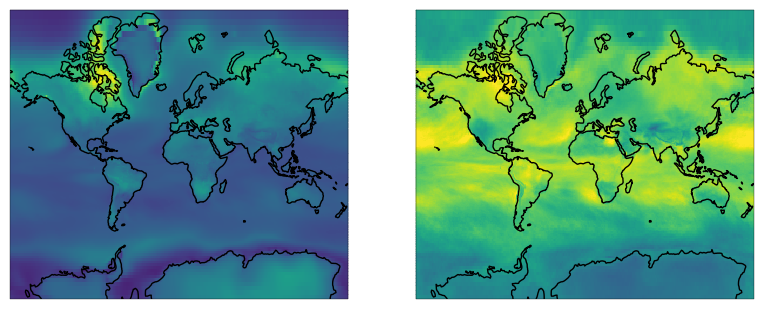

In [188]:
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': ccrs.Mercator()}, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, 2*im_sz*width['one_col'])
ax[0].pcolormesh(ds[0].lon, ds[0].lat, ds[1].T.isel(lev=ind_surf) - ds[0].T.isel(lev=ind_surf),
                 transform=ccrs.PlateCarree(), vmin=0, vmax=15)
ax[1].pcolormesh(ds[0].lon, ds[0].lat, temp_surf_change_zhang,
                 transform=ccrs.PlateCarree(), vmin=0, vmax=15, cmap='viridis')
ax[0].coastlines()
ax[1].coastlines()
plt.show()

In [212]:
def get_exp_quant_array(ds_list, var, lat_ind, lev_ind=None):
    # Returns an n_exp x n_lon array of given variable where ds_list contains n_exp datasets
    var_ind = {'lat': lat_ind, 'lev': lev_ind}
    dims = ds_list[0][var].dims & var_ind.keys()        # only consider dimensions in both variable and var_ind
    return np.asarray([ds_list[i][var].isel({key: var_ind[key] for key in dims}).to_numpy() for i in range(len(ds_list))])

In [197]:
# Compute approx CAPE
if 'rh' not in ds:
    warnings.warn('RH not in ds, so calculating from sphum')
    ds['rh'] = ds['sphum']/sphum_sat(ds['temp'], pressure_surf)
n_lon = ds[0].lon.size
n_lat = ds[0].lat.size
cape_approx = np.zeros((n_exp, n_lat, n_lon))
for i in range(n_exp):
    for j in range(n_lat):
        cape_approx[i, j] = get_cape_approx(ds[i].T.isel(lev=ind_surf, lat=j).to_numpy(), ds[i].rh.isel(lat=j).to_numpy(),
                                            pressure_surf, pressure_ft, ds[i].T.isel(lev=ind_ft, lat=j).to_numpy(),
                                            ds[i].mse_lapse.isel(lat=j).to_numpy())[0]
    ds[i]['cape_approx'] = ds[i].mse_lapse*0 + cape_approx[i]      # use mse_lapse as a base and add to it, as have same dimensions

In [246]:
# Set reference dataset to be average over all regions
ds_ref = [area_weighting(ds[i][['T', 'rh']]).mean(dim=['lat', 'lon']) for i in range(n_exp)]
ds_ref[1]['rh'] = ds_ref[0]['rh']    # set ref RH to be the same in all cases
temp_surf_ref_change = float(ds_ref[1].T.isel(lev=ind_surf) - ds_ref[0].T.isel(lev=ind_surf))

In [241]:
sf_theory = np.zeros((n_lat, n_lon))
for j in range(n_lat):
    sf_theory[j], info_coef, _, info_cont = \
        get_scale_factor_theory(get_exp_quant_array(ds_ref, 'T', j, ind_surf), get_exp_quant_array(ds, 'T', j, ind_surf),
                                get_exp_quant_array(ds_ref, 'rh', j), get_exp_quant_array(ds, 'rh', j),
                                get_exp_quant_array(ds, 'T', j, ind_ft), get_exp_quant_array(ds, 'mse_lapse', j),
                                pressure_surf, pressure_ft, cape_form=True)

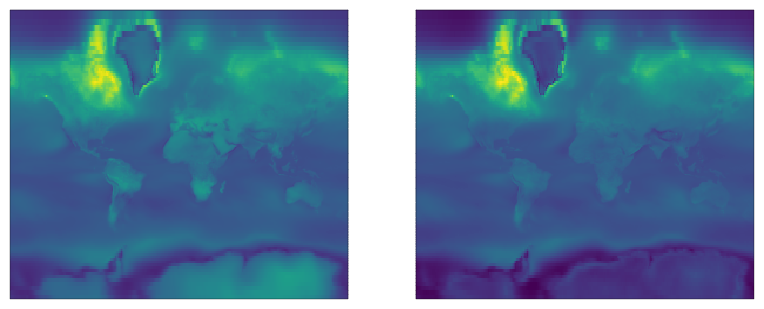

In [249]:
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': ccrs.Mercator()}, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, 2*im_sz*width['one_col'])
ax[0].pcolormesh(ds[0].lon, ds[0].lat, ds[1].T.isel(lev=ind_surf) - ds[0].T.isel(lev=ind_surf),
                 transform=ccrs.PlateCarree(), vmin=0, vmax=15)
ax[1].pcolormesh(ds[0].lon, ds[0].lat, sf_theory * temp_surf_ref_change,
                 transform=ccrs.PlateCarree(), vmin=0, vmax=15, cmap='viridis')